## Introduction

Aortic Senosis (AS) is a degenerative valve condition leading to significant morbidity and mortality. AS is typically diagnosed by humans by reviewing transthoracic echocardiography, which produces images of the heart. Experts must parse through the images to find ones that contain a view of the aortic valve. Thus, the process of diagnosis is time consuming and error prone. The challenge in automating AS screening arises from the need for deep learning networks to mimic a human expert's ability to identify specific views of the aortic valve across those multiple images. Previous approaches to this problem have poor accuracy due to their inflexible averages across images, and normal attention-based multiple instance learning (MIL) models also perform poorly.


The paper, `Detecting Heart Disease from Multi-View Ultrasound Images via Supervised Attention Multiple Instance Learning` proposes a novel MIL-based model with two changes:
- a supervised attention technique guides the learned attention mechanism to favor relevant views
- a self-supervised pretraining strategy applies contrastive learning on the representation of the whole study as opposed to individual images

The paper claims that their proposed approac (SAMIL) has better accuracy (by over 10%) in comparison to ABMIL.
SABMIL, if this accurate in practice, has the potential to transform AS screening by making it less burdensome, more accurate, and more predictable.







## Scope of Reproducibility

The will test the following hypotheses from the paper:

1. Supervised Attention Enhances Model Focus on Relevant Views: It hypothesizes that incorporating supervised attention within the MIL framework will significantly improve the model's ability to identify and prioritize echocardiogram views that are relevant for AS diagnosis. This mechanism is expected to lead to higher diagnostic accuracy by ensuring that the model's predictions are based on the most informative images.

2. Self-Supervised Pretraining Improves Whole-Study Representation Learning: The hypothesis asserts that pretraining the model using a self-supervised strategy that focuses on whole- study representations rather than individual images will enhance the model's ability to understand and interpret the complex anatomical information presented in echocardiograms. This comprehensive learning approach is anticipated to yield a more accurate and robust model for AS screening.

3. SAMIL Outperforms Conventional MIL Approaches in AS Detection: The proposal hypothesizes that the SAMIL framework, with its novel contributions of supervised attention and self-supervised whole-study pretraining, will outperform traditional MIL methods and existing AS detection models in terms of diagnostic accuracy and clinical relevance.

In [5]:
import pandas as pd
import numpy as np
import os
import random

import PIL.Image as Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'PIL'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

### About TMED-2

Our experiment uses Tufts Medical Echocardiogram Dataset-2 (TMED-2) dataset.
  * TMED-2 is a clinically-motivated benchmark dataset for computer vision and machine learning from limited data.
  * This dataset is designed to be an authentic assessment of semi-supervised learning methods that train classifiers from a small, hard-to-acquire labeled dataset and a much larger unlabeled set.
  
The TMED-2 dataset obtained from 2011-2020 at Tufts Medical Center.
  * The TMED-2 dataset contains transthoracic echocardiogram (TTE) imagery, acquired in the course of routine care consistent with American Society of Echocardiography (ASE) guidelines.
  * More information about retrieving the TMED-2 dataset can found [here](https://tmed.cs.tufts.edu/index.html).

The access to the TMED-2 dataset was granted by requesting for the access on [here](https://tmed.cs.tufts.edu/index.html).
  * Further modification wasn't required, and locating the retrieved folder was enough to process the experiment.

### Overview

TMED-2 dataset contains three components:
1. `view_and_diagnosis_labeled_set`: 599 bags from 577 unique patients, where all patients have an AS diagnostic label - (1)none, (2)early AS, or (3)significant AS. Also has view label annotations.
      * This dataset has been partitioned by patient into 360 training / 119 validation / 120 test bags.
2. `view_labeled_set`: 705 bags from 703 unique patients. These bags have view labels, but no AS diagnosis labels.
3. `unlabeled_set`: 5,486 bags from 5,287 patients, and no labels are available for any bags in this set.

### Statistics


Below is the summary table of TMED-2 dataset:

| Dataset            | Num. Patients | Num. Studies | Num. Labeled Images | Num. Unlabeled Images |
|--------------------|---------------|--------------|---------------------|-----------------------|
| fully labeled set  | 577           | 599          | 17,270               | 26,596                 |
| partially labeled set | 703         | 705          | 7,694                | 37,576                 |
| unlabeled set      | 5,287          | 5,486         | 0                   | 353,500                |


### Image Preprocessing

Data processing has been already implemented on the dataset.
* Every image in this dataset is a 2D transthoracic echocardiogram (TTE) image stored at 112x112 pixel resolution in PNG format.

### Illustrations

In [ ]:
def LoadImage(file_path):
    im = Image.open(file_path)
    im = np.asarray(im)/255
    return im

def ShowGrayscaleImage(file_path, title='', ax=None):
    im = LoadImage(file_path)
    if ax is None:
        plt.figure()

    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def find_label(query_key):
    assert len(labels_per_image_csv.index[labels_per_image_csv['query_key']==query_key].tolist())==1

    row_id = labels_per_image_csv.index[labels_per_image_csv['query_key']==query_key].tolist()[0]
    view_label = labels_per_image_csv.iloc[row_id].view_label
    diagnosis_label = labels_per_image_csv.iloc[row_id].diagnosis_label

    return view_label, diagnosis_label

In [ ]:
os.chdir('/content/drive/MyDrive/CS598/TMED2/approved_users_only')

In [ ]:
labels_per_image_csv = pd.read_csv('labels_per_image.csv')
labels_per_image_csv

,query_key,view_label,diagnosis_label
0,4860s1_0.png,A4C,moderate_AS
1,4860s1_1.png,A2C,moderate_AS
2,4860s1_2.png,PLAX,moderate_AS
3,4860s1_3.png,PLAX,moderate_AS
4,4860s1_4.png,PLAX,moderate_AS
...,...,...,...
24959,2797s1_28.png,A4C,Not_Provided
24960,235s1_0.png,PLAX,Not_Provided
24961,235s1_1.png,A4C,Not_Provided
24962,235s1_2.png,PLAX,Not_Provided


Text(0.5, 1.0, 'Diagnosis Label Distribution')

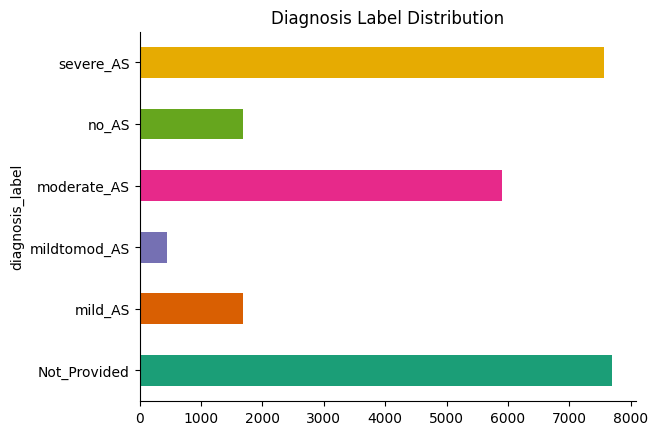

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
labels_per_image_csv.groupby('diagnosis_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Diagnosis Label Distribution')

Text(0.5, 1.0, 'View Label Distribution')

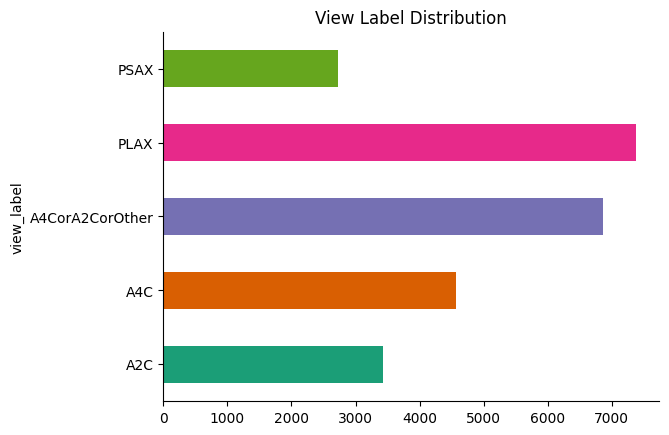

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
labels_per_image_csv.groupby('view_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('View Label Distribution')

**visualization from `view_and_diagnosis_labeled_set`**

In [ ]:
ImageList_view_and_diagnosis_labeled_set = os.listdir('view_and_diagnosis_labeled_set/labeled 2')
print('number of images in the ImageList_view_and_diagnosis_labeledset: {}'.format(len(ImageList_view_and_diagnosis_labeled_set)))

number of images in the ImageList_view_and_diagnosis_labeledset: 14490


In [ ]:
im_to_visualize = random.choice(ImageList_view_and_diagnosis_labeled_set)
view_label, diagnosis_label = find_label(im_to_visualize)

Currently visualizing 1089s1_42.png from labeled set
view: PLAX, diagnosis: severe_AS


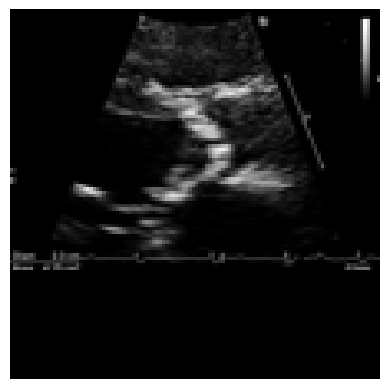

In [ ]:
print('Currently visualizing {} from labeled set'.format(im_to_visualize))
print('view: {}, diagnosis: {}'.format(view_label, diagnosis_label))
ShowGrayscaleImage(os.path.join('view_and_diagnosis_labeled_set/labeled 2', im_to_visualize))

**visualization `from view_labeled_set`**

In [ ]:
ImageList_view_labeledset = os.listdir('view_labeled_set/labeled')
print('number of images in the ImageList_view_labeledset: {}'.format(len(ImageList_view_labeledset)))

number of images in the ImageList_view_labeledset: 7694


In [ ]:
im_to_visualize = random.choice(ImageList_view_labeledset)
view_label, diagnosis_label = find_label(im_to_visualize)

Currently visualizing 4465s1_2.png from labeled set
view: A2C, diagnosis: Not_Provided


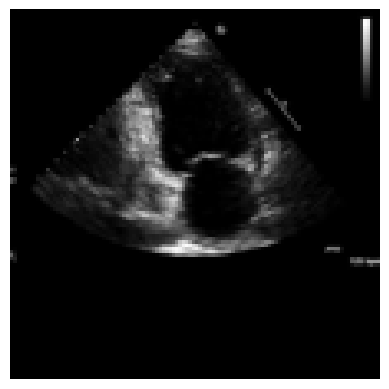

In [ ]:
print('Currently visualizing {} from labeled set'.format(im_to_visualize))
print('view: {}, diagnosis: {}'.format(view_label, diagnosis_label))
ShowGrayscaleImage(os.path.join('view_labeled_set/labeled', im_to_visualize))